# Overview

Notebook ini digunakan untuk mengaplikasikan model forecasting pada produk pareto di data

# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, silhouette_score
from sklearn.ensemble import RandomForestRegressor

from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
from mlforecast.lag_transforms import ExpandingMean

import pickle
from itertools import product

# Importing the Data

In [2]:
df = pd.read_parquet('data/preprocessed/forecast_ready.parquet')

In [3]:
df.head()

,unique_id,sku_id,country,ds,quantity,gmv,total_order,total_customer,price,missing_quantity,quantity_count,quantity_mean,quantity_median,quantity_std_dev,quantity_min,quantity_max,missing_quantity_mean,quantity_cv
0,10002 | AUSTRALIA,10002,AUSTRALIA,2010-03-01,12.0,10.2,1.0,1.0,0.85,False,21,1.714286,0.0,5.737097,0.0,24.0,0.904762,3.34664
1,10002 | AUSTRALIA,10002,AUSTRALIA,2010-04-01,0.0,0.0,0.0,0.0,0.85,True,21,1.714286,0.0,5.737097,0.0,24.0,0.904762,3.34664
2,10002 | AUSTRALIA,10002,AUSTRALIA,2010-05-01,0.0,0.0,0.0,0.0,0.85,True,21,1.714286,0.0,5.737097,0.0,24.0,0.904762,3.34664
3,10002 | AUSTRALIA,10002,AUSTRALIA,2010-06-01,0.0,0.0,0.0,0.0,0.85,True,21,1.714286,0.0,5.737097,0.0,24.0,0.904762,3.34664
4,10002 | AUSTRALIA,10002,AUSTRALIA,2010-07-01,0.0,0.0,0.0,0.0,0.85,True,21,1.714286,0.0,5.737097,0.0,24.0,0.904762,3.34664


Secara realistis, forecast butuh banyak data agar model dapat mempelajari pattern dari masing masing series. Maka kita akan men-*exclude* series yang:
- Sudah tidak ada sales di 3 bulan lalu (Kemungkinan besar sudah inaktif)
- Memiliki panjang series kurang dari 6 bulan (New product belum punya cukup data)

In [4]:
# Date Latest
max_date = df['ds'].max()

# cutoff date
three_months_ago = max_date - pd.DateOffset(months=3) # Untuk produk inaktif
six_months_ago = max_date - pd.DateOffset(months=6) # Untuk produk baru

In [5]:
# Dapatkan recent sales (3 bulan lalu)
recent_data = df[df['ds'] >= three_months_ago]
# Cari yang total quantity nya 0, itu yang tidak aktif, simpan unique_id nya
inactive_ids = (
    recent_data.groupby('unique_id')['quantity']
    .sum()
    .loc[lambda x: x == 0]
    .index
) 

# Dapatkan tanggal (ds) sales pertama per unique_id
first_seen = df.groupby('unique_id')['ds'].min()

# Cari yang first seen nya masih dalam 6 bulan lalu, simpan unique_id nya
new_ids = first_seen[first_seen >= six_months_ago].index

# Gabungkan untuk di exclude
exclude_ids = set(inactive_ids) | set(new_ids)

# filtered dataframe
filtered_df = df[~df['unique_id'].isin(exclude_ids)]
new_series_df = df[df['unique_id'].isin(new_ids)]
inactive_series_df = df[df['unique_id'].isin(inactive_ids)]

# Remove overlap new series dengan inactive series
new_series_df = new_series_df[
    ~new_series_df['unique_id'].isin(inactive_series_df['unique_id'])
]

Catatan:
- series yang tidak aktif dapat otomatis kita forecast 0
- series yang masih baru, dapat kita aplikasikan historical average

# Take Pareto Products

Untuk mempersingkat waktu training, kita akan fokus ke produk pareto saja, yaitu top produk yang berkontribusi ke 80% sales. Akan kita lihat pareto dari keseluruhan negara

In [6]:
# Dapatkan sales per produk untuk dari seluruh negara
sales_per_product = filtered_df.groupby('sku_id').agg(
    {'quantity':'sum'}
    ).reset_index().sort_values('quantity',ascending=False)

# Dapatkan cumulativenya
sales_per_product['cumulative_quantity'] = sales_per_product['quantity'].cumsum()
# Percentage nya
sales_per_product['cumulative_percentage'] = sales_per_product['cumulative_quantity']/sales_per_product['quantity'].sum()
# Flag pareto jika cumulative percentage < 80%
sales_per_product['pareto_flag'] = sales_per_product['cumulative_percentage'] <= 0.8
# Ambil pareto product
pareto_product = sales_per_product[sales_per_product['pareto_flag']][['sku_id']]

In [7]:
pareto_df = filtered_df.merge(pareto_product,on='sku_id')
non_pareto_df = filtered_df[~filtered_df['sku_id'].isin(pareto_product['sku_id'])]

# Split Time Series

Dengan data hanya 2 tahun historis, secara realistis tidak mungkin kita tiba tiba bisa forecast 1 tahun kedepan secara akurat, oleh karena itu, akan kita coba forecast 3 bulan kedepan.

Kita akan memilah data jadi **train**, **test**

In [8]:
# Pastikan data sudah diurutkan berdasarkan tanggal
pareto_df = pareto_df.sort_values(['unique_id','ds']).reset_index()

In [9]:
# Horizon = Panjang series = 3
horizon = 3

# Cutoff untuk split
cutoff_date = max_date - pd.DateOffset(months=3)

# Bagi data jadi train dan test
train_df = pareto_df[pareto_df['ds']<=cutoff_date].rename(columns={'quantity':'y'})
test_df = pareto_df[pareto_df['ds']>cutoff_date].rename(columns={'quantity':'y'})

# Pastikan unique id yang di test_df ada di train_df
test_df = test_df[test_df['unique_id'].isin(train_df['unique_id'].unique())]

# Metodologi

In [10]:
print('Total Unique ID:',train_df['unique_id'].nunique())

Total Unique ID: 3420


Karena kita punya 3420 unique ID, cukup *tedious* jika kita loop untuk train model satu persatu.

Secara Teori, Metode Forecasting bisa dibagi kedalam 2 approach

Local Model: Yaitu 1 model per unique_id, contoh model ARIMA, Exponential Time Smoothing, Prophet, atau model klasik statistika lainnya
Global Model: Yaitu 1 model untuk banyak unique_id

Pros dan Cons nya adalah, 
Local Model:
- (+) Dapat memperhatikan pattern yang lebih detail **walaupun**
- (-) Bisa jadi terlalu memperhatikan pattern di series tersebut (Overfit)

Global Model:
- (+) Banyak data untuk di train, jadi bisa mendapat pattern secara umum, **walaupun**
- (-) Mungkin tak semua data yang di input relevan atau mungkin terlalu general

Untuk mengambil titik tengahnya, kita akan coba **Clustering Time Series**, yaitu mengelompokan series yang memang punya karateristik yang mirip, dan mem-*fitting* satu model untuk tiap cluster

# Clustering Time Series

In [11]:
 # Ambil fitur yang telah kita buat di tahap sebelumnya
cluster_features = [
    "quantity_mean", "quantity_median", "quantity_std_dev",
    "quantity_min", "quantity_max", "missing_quantity_mean", "quantity_cv"
]

# Drop duplicate (kita tidak perlu ds dan quantity)
df_cluster = train_df[['unique_id'] + cluster_features].drop_duplicates().fillna(0)

Setelah mendapatkan fitur untuk di cluster, selanjutnya kita dapat clustering dengan K-Means

In [12]:
# Scale data terlebih dahulu, karena tiap series pasti punya quantity berbeda beda
scaler = MinMaxScaler()
# Fit ke df_cluster untuk cluster features saja (exclude unique_id)
X = scaler.fit_transform(df_cluster[cluster_features])

Untuk menentukan jumlah cluster terbaik, kita dapat menggunakan *Silhouette Score*

In [13]:
def plot_silhouette_scores(X, k_min=2, k_max=10):
    scores = []
    for k in range(k_min, k_max + 1):
        kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
        score = silhouette_score(X, kmeans.labels_)
        scores.append(score)

    plt.figure(figsize=(8, 4))
    plt.plot(range(k_min, k_max + 1), scores, marker='o')
    plt.title('Silhouette Score per k')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


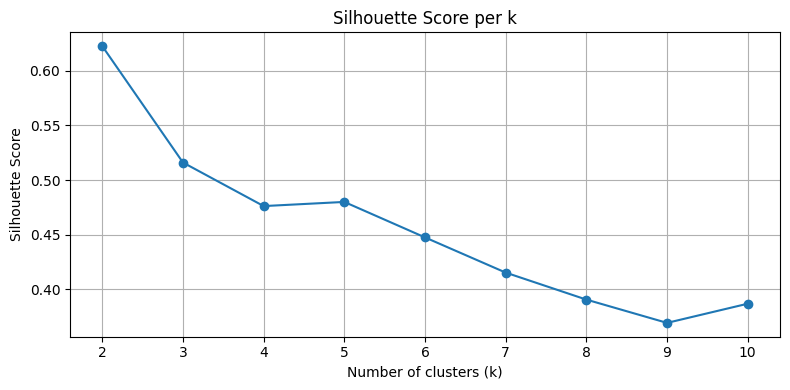

In [14]:
plot_silhouette_scores(X, k_min=2, k_max=10)

Sepertinya 4 Cluster adalah angka yang paling cocok

In [15]:
kmeans = KMeans(n_clusters=4, random_state=42)
df_cluster["cluster"] = kmeans.fit_predict(X)

In [16]:
# Dapatkan mean value dari masing masing fitur untuk tiap cluster
df_cluster.groupby('cluster')[cluster_features].mean().T

cluster,0,1,2,3
quantity_mean,50.725669,11.253970,341.362648,6.321670
quantity_median,17.827011,0.021953,272.038798,0.014184
quantity_std_dev,94.233623,20.796283,258.670106,18.299843
quantity_min,0.000000,0.000000,63.908636,0.000000
quantity_max,329.409712,68.452509,1052.201502,69.877069
missing_quantity_mean,0.393335,0.668737,0.034972,0.819142
quantity_cv,1.325284,1.796643,0.818426,2.646384


Jika kita lihat masing masing cluster:
- Cluster 2 adalah cluster dengan quantity tinggi dan CV rendah, artinya series konsisten / stabil memiliki high quantity
- Cluster 3 merupakan cluster yang paling volatile, dengan CV paling tinggi dan rata rata penjualan yang relatif kecil (max 70), kemungkinan besar ini series yang memiliki low sales dan on & off (Missing quantity_mean nya cukup besar, secara rata-rata 82% data missing)
- Cluster 0 merupakan series yang bisa dibilang ditengah tengah, quantity sales relatif sedang, kadang tidak punya sales, CV tidak terlalu besar

Mari kita merge data cluster tersebut ke train dan test

In [17]:
train_df = pd.merge(train_df, df_cluster[['unique_id', 'cluster']], how='left', on='unique_id')

In [18]:
test_df = pd.merge(test_df, df_cluster[['unique_id', 'cluster']], how='left', on='unique_id')

Lalu kita visualisasikan masing masing cluster

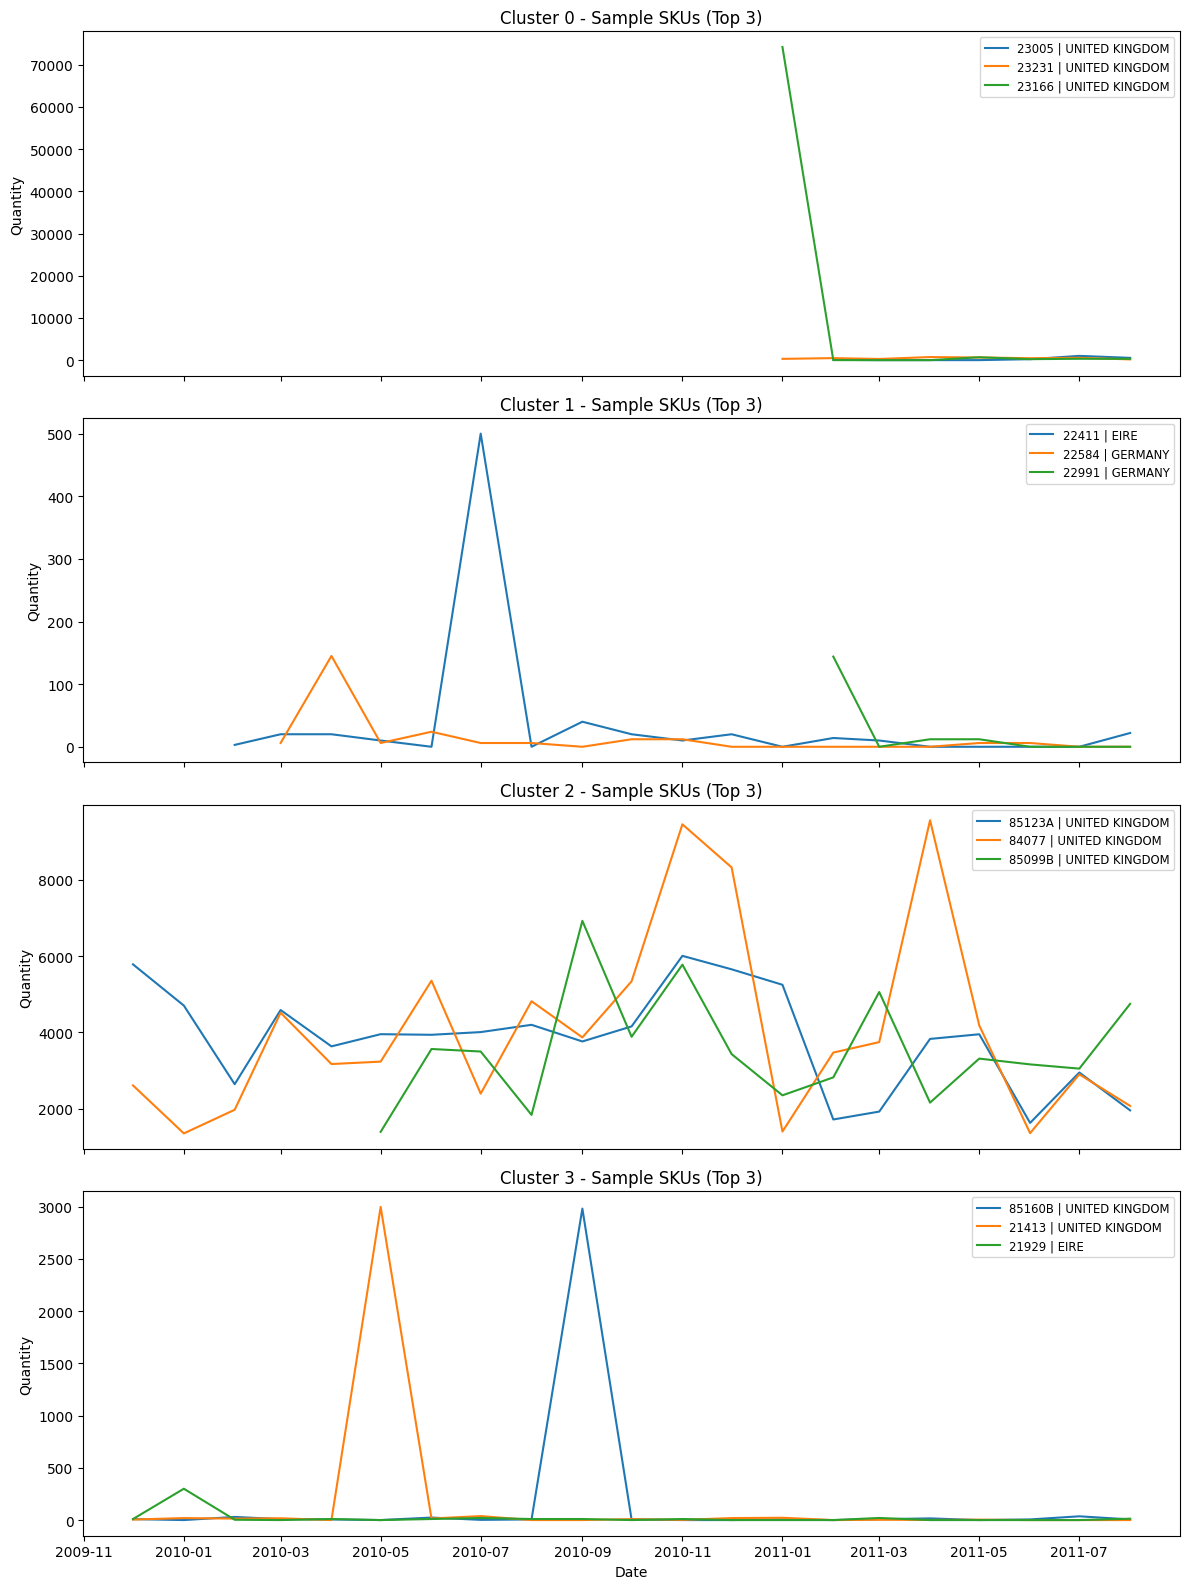

In [19]:
n_clusters = train_df['cluster'].nunique()
# SubPlot setting
fig, axs = plt.subplots(n_clusters, 1, figsize=(12, 4 * n_clusters), sharex=True)

for i in range(n_clusters):
    ax = axs[i] if n_clusters > 1 else axs
    cluster_df = train_df[train_df['cluster'] == i]

    # Sort dari median terbesar
    cluster_df = cluster_df.sort_values('quantity_median',ascending=False)
    
    # Ambil 3 SKU terbesar
    unique_ids = cluster_df['unique_id'].unique()[:3]

    for uid in unique_ids:
        sku_df = cluster_df[cluster_df['unique_id'] == uid].sort_values('ds')
        ax.plot(sku_df['ds'], sku_df['y'], label=uid)

    ax.set_title(f"Cluster {i} - Sample SKUs (Top 3)")
    ax.set_ylabel("Quantity")
    ax.legend(fontsize='small')

plt.xlabel("Date")
plt.tight_layout()
plt.show()


# Training Model

Untuk train model untuk Forecast, salah satu library yang relatif cukup mudah digunakan adalah **Nixtlaverse** Package (**statsforecast, mlforecast, neuralforecast**). 

Library nya cukup mendapatkan input **unique_id**, **ds**, dan **y**. Dan pipeline mereka bisa train multiple time series secara bersamaan

Untuk modul ini, kita tidak akan terlalu dalam ke hyperparameter tuning, dan akan memfokuskan ke fitur apa yang bisa dipakai. Untuk model, kita bisa pakai **Random Forest** yang cukup **robust**

## Random Forest + MLForecast

In [20]:
# Dictionary untuk penyimpanan result per cluster
all_forecasts = []

# Loop over clusters
for cluster_id in train_df['cluster'].unique():
    print(f'Fitting cluster: {cluster_id}')
    
    # Filter data
    cluster_df = train_df[train_df['cluster'] == cluster_id]

    # Gunakan base RF
    rf = RandomForestRegressor(n_jobs=-1, random_state=42)

    # MLForecast Pipeline dengan RF
    mforc = MLForecast(
        models={'yhat': rf},
        freq='MS',
        lags=[1, 3, 6, 12], # Lag 1 bulan lalu, 3 bulan lalu, dst
        lag_transforms={
            3: [ExpandingMean()], # Mirip Rolling Mean 3 bulan, tapi aman untuk data pendek
            6: [ExpandingMean()],
            12: [ExpandingMean()]
        },
        date_features=['month', 'quarter', 'year'], # Fitur tanggal
        num_threads=1,
        target_transforms=[Differences([1])]
    )

    # Fit model
    mforc.fit(
        cluster_df[['unique_id', 'ds', 'y']].fillna(0),
        id_col='unique_id',
        time_col='ds',
        target_col='y',
        dropna=False
    )

    # Forecast 3 bulan kedepan
    fcst = mforc.predict(horizon)

    # Tambahkan nomor cluster 
    fcst['cluster'] = cluster_id

    # Simpan
    all_forecasts.append(fcst)

Fitting cluster: 3


C:\Users\PC\anaconda3\envs\Kalbe-test\Lib\site-packages\mlforecast\core.py:625: UserWarning: Found null values in lag6, lag12, expanding_mean_lag6, expanding_mean_lag12.
  warnings.warn(f'Found null values in {", ".join(cols_with_nulls)}.')
C:\Users\PC\anaconda3\envs\Kalbe-test\Lib\site-packages\mlforecast\core.py:625: UserWarning: Found null values in lag6, lag12, expanding_mean_lag6, expanding_mean_lag12.
  warnings.warn(f'Found null values in {", ".join(cols_with_nulls)}.')
C:\Users\PC\anaconda3\envs\Kalbe-test\Lib\site-packages\mlforecast\core.py:625: UserWarning: Found null values in lag12, expanding_mean_lag6, expanding_mean_lag12.
  warnings.warn(f'Found null values in {", ".join(cols_with_nulls)}.')


Fitting cluster: 2


C:\Users\PC\anaconda3\envs\Kalbe-test\Lib\site-packages\mlforecast\core.py:625: UserWarning: Found null values in lag6, lag12, expanding_mean_lag6, expanding_mean_lag12.
  warnings.warn(f'Found null values in {", ".join(cols_with_nulls)}.')
C:\Users\PC\anaconda3\envs\Kalbe-test\Lib\site-packages\mlforecast\core.py:625: UserWarning: Found null values in lag6, lag12, expanding_mean_lag6, expanding_mean_lag12.
  warnings.warn(f'Found null values in {", ".join(cols_with_nulls)}.')
C:\Users\PC\anaconda3\envs\Kalbe-test\Lib\site-packages\mlforecast\core.py:625: UserWarning: Found null values in lag12, expanding_mean_lag6, expanding_mean_lag12.
  warnings.warn(f'Found null values in {", ".join(cols_with_nulls)}.')


Fitting cluster: 1


C:\Users\PC\anaconda3\envs\Kalbe-test\Lib\site-packages\mlforecast\core.py:625: UserWarning: Found null values in lag6, lag12, expanding_mean_lag6, expanding_mean_lag12.
  warnings.warn(f'Found null values in {", ".join(cols_with_nulls)}.')
C:\Users\PC\anaconda3\envs\Kalbe-test\Lib\site-packages\mlforecast\core.py:625: UserWarning: Found null values in lag6, lag12, expanding_mean_lag6, expanding_mean_lag12.
  warnings.warn(f'Found null values in {", ".join(cols_with_nulls)}.')
C:\Users\PC\anaconda3\envs\Kalbe-test\Lib\site-packages\mlforecast\core.py:625: UserWarning: Found null values in lag12, expanding_mean_lag6, expanding_mean_lag12.
  warnings.warn(f'Found null values in {", ".join(cols_with_nulls)}.')


Fitting cluster: 0


C:\Users\PC\anaconda3\envs\Kalbe-test\Lib\site-packages\mlforecast\core.py:625: UserWarning: Found null values in lag6, lag12, expanding_mean_lag6, expanding_mean_lag12.
  warnings.warn(f'Found null values in {", ".join(cols_with_nulls)}.')
C:\Users\PC\anaconda3\envs\Kalbe-test\Lib\site-packages\mlforecast\core.py:625: UserWarning: Found null values in lag6, lag12, expanding_mean_lag6, expanding_mean_lag12.
  warnings.warn(f'Found null values in {", ".join(cols_with_nulls)}.')
C:\Users\PC\anaconda3\envs\Kalbe-test\Lib\site-packages\mlforecast\core.py:625: UserWarning: Found null values in lag12, expanding_mean_lag6, expanding_mean_lag12.
  warnings.warn(f'Found null values in {", ".join(cols_with_nulls)}.')


In [21]:
# Gabungkan forecast semua cluster
forecast_df = pd.concat(all_forecasts, ignore_index=True)

# Evaluasi Model

Metric yang akan kita gunakan adalah, MSE, MAE, dan sMAPE untuk menghindari inflated number

In [22]:
# Merge dengan test data
merged_df = test_df.merge(forecast_df,on=['unique_id','ds','cluster'])

In [23]:
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.abs(y_true - y_pred) / denominator
    return np.mean(diff.replace([np.inf, -np.inf], 0).fillna(0)) * 100
    
# Fungsi untuk calculate metric per group
def calc_metrics(group):
    return pd.Series({
        'MSE': mean_squared_error(group['y'], group['yhat']),
        'MAE': mean_absolute_error(group['y'], group['yhat']),
        # Untuk sMAPE, tambah 0.1 untuk menghindari pembagian oleh 0
        'SMAPE(%)': smape(group['y']+0.1, group['yhat']+0.1)
    })

# Apply per unique_id
metrics_per_id = merged_df[['cluster','unique_id', 'sku_id', 'country', 'ds', 'y', 'yhat']].groupby(['cluster','unique_id']).apply(calc_metrics).reset_index()

C:\Users\PC\AppData\Local\Temp\ipykernel_2668\3492873803.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_per_id = merged_df[['cluster','unique_id', 'sku_id', 'country', 'ds', 'y', 'yhat']].groupby(['cluster','unique_id']).apply(calc_metrics).reset_index()


In [24]:
metrics_per_id[['MSE','MAE','SMAPE(%)']].describe().round(2)

,MSE,MAE,SMAPE(%)
count,3420.00,3420.00,3420.00
mean,60495.34,80.27,126.91
std,437692.70,199.39,50.46
min,0.18,0.35,4.38
25%,92.75,8.10,90.99
50%,409.92,17.11,137.20
75%,5167.97,60.27,167.26
max,10571007.18,2765.76,200.00


Secara overall, metric kita cukup buruk, mari kita lihat per cluster

In [25]:
metrics_per_id.groupby('cluster').describe().round(2).T

cluster                  0           1            2          3
MSE      count      659.00     1116.00       799.00     846.00
         mean     76822.55     3521.27    188281.75    2247.22
         std     518176.53    37988.77    756626.64   13324.31
         min          1.12        1.03        99.57       0.18
         25%        134.85       58.03      6421.35      34.35
         50%        506.23      170.16     26703.80     144.18
         75%       2809.55      616.35     90021.48     504.93
         max    8995827.84  1119267.42  10571007.18  276988.43
MAE      count      659.00     1116.00       799.00     846.00
         mean        75.92       21.96       231.81      17.47
         std        227.85       43.73       303.40      28.36
         min          0.98        0.68         8.22       0.35
         25%         10.07        6.61        69.75       4.81
         50%         19.17       11.04       144.02       9.55
         75%         45.41       21.01       252.98      17.74
         max       2587.83      888.69      2765.76     310.20
SMAPE(%) count      659.00     1116.00       799.00     846.00
         mean       116.11      148.46        69.87     160.77
         std         41.01       32.86        42.83      30.08
         min         12.16       14.76         4.38      46.58
         25%         88.69      130.29        36.71     141.19
         50%        115.69      149.89        60.74     166.27
         75%        145.08      172.96        92.41     187.48
         max        200.00      199.80       199.96     199.83

# Refleksi Metodologi

Berdasarkan SMAPE, cluster yang paling *mendingan* adalah cluster 2, walaupun masih dengan median 60% (~Akurasi 40%).

Cluster 2 punya hasil yang tidak terlalu buruk karena series series nya **stabil** dan tidak terlalu fluktuatif. Dari kelengkapan series nya juga cukup lengkap, tidak banyak sales yang 0

Karateristik ini yang biasanya menentukan apakah suatu series *forecast-able* atau tidak, dan **effort sebaiknya tertuju kepada tuning model untuk series di Cluster 2** ini. Untuk cluster lainnya, mungkin sudah *gak ketolong* dan bisa di kasih average saja

In [26]:
metrics_per_id[metrics_per_id['cluster']==2].sort_values('SMAPE(%)')

,cluster,unique_id,MSE,MAE,SMAPE(%)
2530,2,84692 | UNITED KINGDOM,1879.916867,28.213333,4.376910
2435,2,22998 | UNITED KINGDOM,8298.704323,68.241944,4.384508
2254,2,22557 | UNITED KINGDOM,684.169674,23.300000,6.956300
2207,2,22457 | UNITED KINGDOM,6026.365837,61.128889,7.617145
2123,2,22196 | UNITED KINGDOM,289.047800,16.980000,8.385439
...,...,...,...,...,...
1837,2,20966 | UNITED KINGDOM,18433.818200,128.940000,199.653128
1940,2,21507 | UNITED KINGDOM,36264.638467,188.486667,199.783619
2384,2,22855 | UNITED KINGDOM,61590.705581,233.321111,199.799592
1859,2,21069 | UNITED KINGDOM,225478.457367,471.756667,199.914124


## Sample of Good Forecast

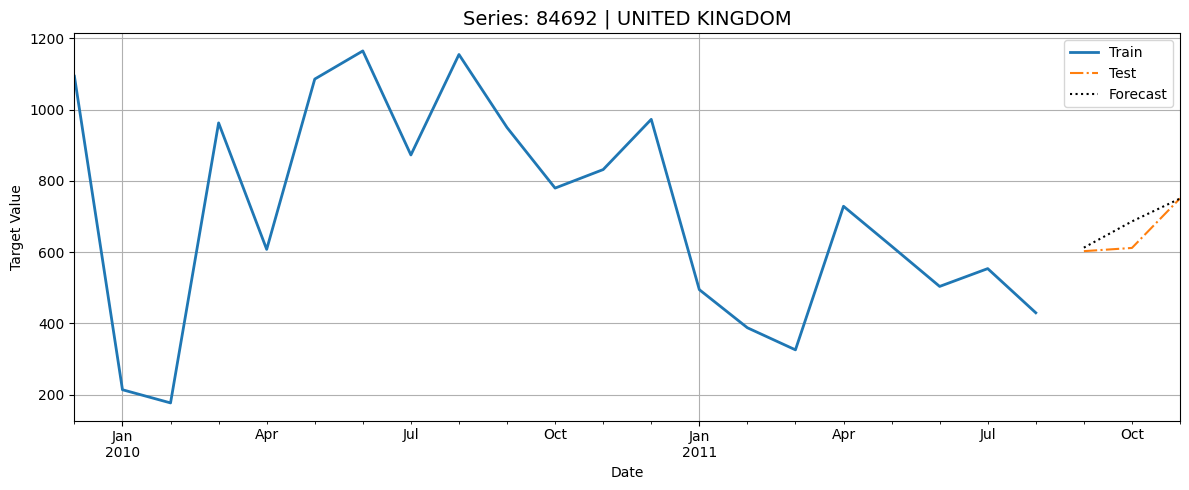

In [27]:
# Sample series
sample_id = '84692 | UNITED KINGDOM'

# Filter data train, test, dan prediksi untuk id tersebut
plot_train = train_df[train_df.unique_id == sample_id][['ds', 'y']].set_index('ds')
plot_test  = merged_df[merged_df.unique_id == sample_id][['ds', 'y']].set_index('ds')
plot_pred  = merged_df[merged_df.unique_id == sample_id][['ds', 'yhat']].set_index('ds')

# Plot setting
plt.figure(figsize=(12, 5))
ax = plot_train['y'].plot(label='Train', linewidth=2)

plot_test['y'].plot(ax=ax, label='Test', linestyle='-.')
plot_pred['yhat'].plot(ax=ax, label='Forecast', linestyle=':', color='black')

ax.set_title(f'Series: {sample_id}', fontsize=14)
ax.set_ylabel('Target Value')
ax.set_xlabel('Date')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


## Sample of Bad Forecast

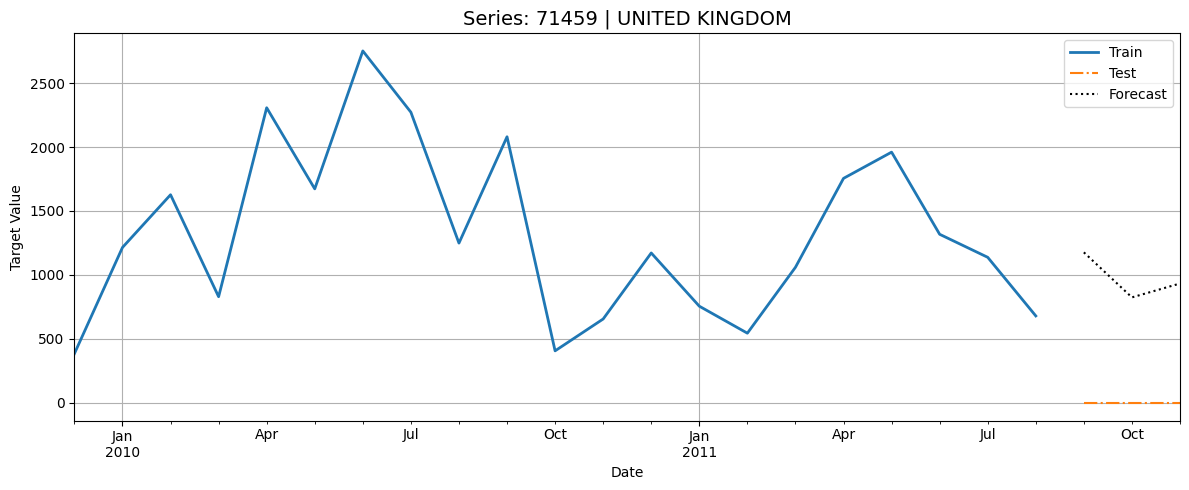

In [28]:
# Sample series
sample_id = '71459 | UNITED KINGDOM'

# Filter data train, test, dan prediksi untuk id tersebut
plot_train = train_df[train_df.unique_id == sample_id][['ds', 'y']].set_index('ds')
plot_test  = merged_df[merged_df.unique_id == sample_id][['ds', 'y']].set_index('ds')
plot_pred  = merged_df[merged_df.unique_id == sample_id][['ds', 'yhat']].set_index('ds')

# Plot setting
plt.figure(figsize=(12, 5))
ax = plot_train['y'].plot(label='Train', linewidth=2)

plot_test['y'].plot(ax=ax, label='Test', linestyle='-.')
plot_pred['yhat'].plot(ax=ax, label='Forecast', linestyle=':', color='black')

ax.set_title(f'Series: {sample_id}', fontsize=14)
ax.set_ylabel('Target Value')
ax.set_xlabel('Date')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


Untuk series diatas, mau modelnya di tuning secanggih apapun, tidak akan bisa expect salesnya drop jadi 0. Mari coba cek yang akurasinya ditengah tengah

In [29]:
# Simpan temporarily
temp = metrics_per_id[metrics_per_id['cluster']==2].sort_values('SMAPE(%)')
# Ambil index tengah tengah
temp.iloc[len(temp) // 2]

cluster                           2
unique_id    22792 | UNITED KINGDOM
MSE                    81040.319496
MAE                      225.075556
SMAPE(%)                  60.736385
Name: 2371, dtype: object

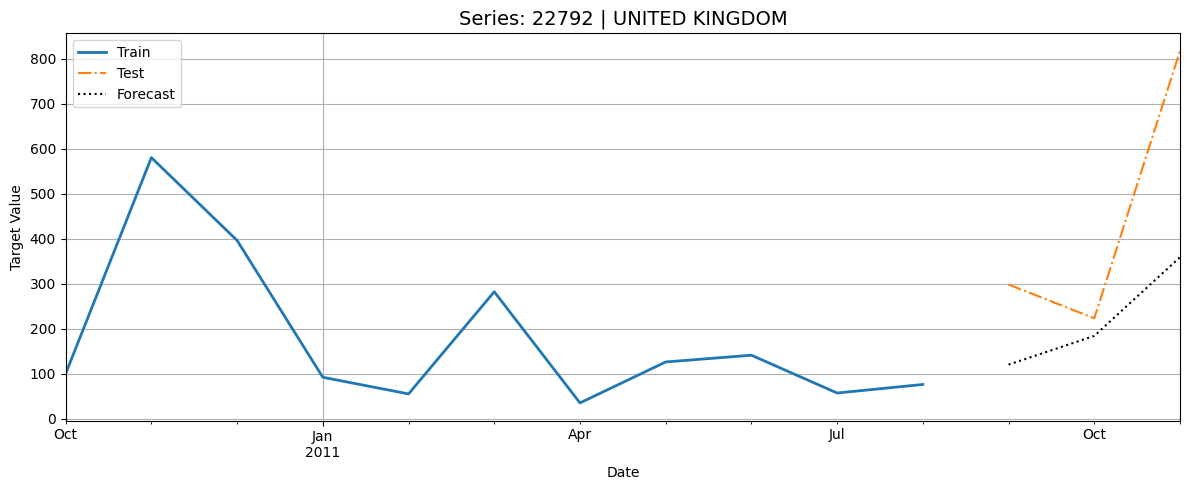

In [30]:
# Sample series
sample_id = '22792 | UNITED KINGDOM'

# Filter data train, test, dan prediksi untuk id tersebut
plot_train = train_df[train_df.unique_id == sample_id][['ds', 'y']].set_index('ds')
plot_test  = merged_df[merged_df.unique_id == sample_id][['ds', 'y']].set_index('ds')
plot_pred  = merged_df[merged_df.unique_id == sample_id][['ds', 'yhat']].set_index('ds')

# Plot setting
plt.figure(figsize=(12, 5))
ax = plot_train['y'].plot(label='Train', linewidth=2)

plot_test['y'].plot(ax=ax, label='Test', linestyle='-.')
plot_pred['yhat'].plot(ax=ax, label='Forecast', linestyle=':', color='black')

ax.set_title(f'Series: {sample_id}', fontsize=14)
ax.set_ylabel('Target Value')
ax.set_xlabel('Date')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

Secara visual, forecastnya sudah benar mengikuti pola sebelumnya untuk Oktober - November, namun masih terlalu konservatif. Butuh lebih banyak data jika memang pola ini seasonal atau bukan

# Point To Explore

Dari modul ini, kita sudah coba eksplorasi forecast pada produk pareto, dan menemukan bahwa ada cluster yang mungkin dapat di forecast. Hal-hal yang dapat di eskplorasi kedepannya adalah:
- Eksplorasi model lain
- Hyperparameter Tuning
- Penambahan fitur Price atau data Event jika ada
- Hierarchical Forecasting untuk memastikan sales per negara dan sales global punya jumlah yang sama

# Output Finalization

Sebelumnya kita punya:
- inactive_series_df
- new_series_df
- pareto_df
- non_pareto_df

Mari formulasikan forecast akhir dari masing masing data

## Forecast Inactive Series

Untuk inactive series, akan kita forecast dengan 0

In [31]:
# Create future tanggal
future_ds = pd.DataFrame({'ds':pd.date_range(start=max_date+pd.DateOffset(months=1), periods=3, freq='MS')})

# Ambil unique combination dari inactive series
future_inactive_series_df = inactive_series_df[['unique_id', 'sku_id', 'country']].drop_duplicates()
# Assign kolom key ke future_inactive_series_df dan future_ds, merge dengan kolomn key tersebut, lalu drop
future_inactive_series_df = future_inactive_series_df.assign(key=1).merge(future_ds.assign(key=1),on='key').drop(columns='key')
# Set quantity jadi 0
future_inactive_series_df['forecast_quantity'] = 0

## Forecast New and Non Pareto

Untuk new dan non pareto, dapat kita forecast dengan 6 month average

In [32]:
# Gabungkan kedua dataframe
to_average_forecast_df = pd.concat([new_series_df,non_pareto_df])
# Dapatkan last 6 observation dari tiap series_id, 
to_average_forecast_df = to_average_forecast_df.sort_values('ds').groupby(['unique_id','sku_id','country']).tail(6).reset_index()
# lalu hitung average nya
to_average_forecast_df = to_average_forecast_df.groupby(['unique_id','sku_id','country']).agg({'quantity':'mean'}).reset_index()


# Lakukan hal yang serupa untuk mergin dengan future_ds
to_average_forecast_df = to_average_forecast_df.assign(key=1).merge(future_ds.assign(key=1),on='key').drop(columns='key')
to_average_forecast_df = to_average_forecast_df.rename(columns={'quantity':'forecast_quantity'})

## Forecast Pareto on Full Data

In [33]:
# Merge cluster ke dalam pareto_df (atau anda dapat men-cluster ulang dengan full data)
pareto_df = pd.merge(pareto_df, df_cluster[['unique_id', 'cluster']], how='left', on='unique_id')

In [34]:
# Dictionary untuk penyimpanan result per cluster
all_forecasts = []

# Loop over clusters
for cluster_id in pareto_df['cluster'].unique():
    print(f'Fitting cluster: {cluster_id}')
    
    # Filter data
    cluster_df =  pareto_df[pareto_df['cluster'] == cluster_id]

    # Gunakan base RF
    rf = RandomForestRegressor(n_jobs=-1, random_state=42)

    # MLForecast Pipeline dengan RF
    mforc = MLForecast(
        models={'yhat': rf},
        freq='MS',
        lags=[1, 3, 6, 12], # Lag 1 bulan lalu, 3 bulan lalu, dst
        lag_transforms={
            3: [ExpandingMean()], # Mirip Rolling Mean 3 bulan, tapi aman untuk data pendek
            6: [ExpandingMean()],
            12: [ExpandingMean()]
        },
        date_features=['month', 'quarter', 'year'], # Fitur tanggal
        num_threads=1,
        target_transforms=[Differences([1])]
    )

    # Fit model
    mforc.fit(
        cluster_df[['unique_id', 'ds', 'quantity']].rename(columns={'quantity':'y'}).fillna(0),
        id_col='unique_id',
        time_col='ds',
        target_col='y',
        dropna=False
    )

    # Forecast 3 bulan kedepan
    fcst = mforc.predict(horizon)

    # Tambahkan nomor cluster 
    fcst['cluster'] = cluster_id

    # Simpan
    all_forecasts.append(fcst)

Fitting cluster: 3


C:\Users\PC\anaconda3\envs\Kalbe-test\Lib\site-packages\mlforecast\core.py:625: UserWarning: Found null values in lag12, expanding_mean_lag12.
  warnings.warn(f'Found null values in {", ".join(cols_with_nulls)}.')
C:\Users\PC\anaconda3\envs\Kalbe-test\Lib\site-packages\mlforecast\core.py:625: UserWarning: Found null values in lag12, expanding_mean_lag12.
  warnings.warn(f'Found null values in {", ".join(cols_with_nulls)}.')
C:\Users\PC\anaconda3\envs\Kalbe-test\Lib\site-packages\mlforecast\core.py:625: UserWarning: Found null values in lag12, expanding_mean_lag12.
  warnings.warn(f'Found null values in {", ".join(cols_with_nulls)}.')


Fitting cluster: 2


C:\Users\PC\anaconda3\envs\Kalbe-test\Lib\site-packages\mlforecast\core.py:625: UserWarning: Found null values in lag12, expanding_mean_lag12.
  warnings.warn(f'Found null values in {", ".join(cols_with_nulls)}.')
C:\Users\PC\anaconda3\envs\Kalbe-test\Lib\site-packages\mlforecast\core.py:625: UserWarning: Found null values in lag12, expanding_mean_lag12.
  warnings.warn(f'Found null values in {", ".join(cols_with_nulls)}.')
C:\Users\PC\anaconda3\envs\Kalbe-test\Lib\site-packages\mlforecast\core.py:625: UserWarning: Found null values in lag12, expanding_mean_lag12.
  warnings.warn(f'Found null values in {", ".join(cols_with_nulls)}.')


Fitting cluster: 1


C:\Users\PC\anaconda3\envs\Kalbe-test\Lib\site-packages\mlforecast\core.py:625: UserWarning: Found null values in lag12, expanding_mean_lag12.
  warnings.warn(f'Found null values in {", ".join(cols_with_nulls)}.')
C:\Users\PC\anaconda3\envs\Kalbe-test\Lib\site-packages\mlforecast\core.py:625: UserWarning: Found null values in lag12, expanding_mean_lag12.
  warnings.warn(f'Found null values in {", ".join(cols_with_nulls)}.')
C:\Users\PC\anaconda3\envs\Kalbe-test\Lib\site-packages\mlforecast\core.py:625: UserWarning: Found null values in lag12, expanding_mean_lag12.
  warnings.warn(f'Found null values in {", ".join(cols_with_nulls)}.')


Fitting cluster: 0


C:\Users\PC\anaconda3\envs\Kalbe-test\Lib\site-packages\mlforecast\core.py:625: UserWarning: Found null values in lag12, expanding_mean_lag12.
  warnings.warn(f'Found null values in {", ".join(cols_with_nulls)}.')
C:\Users\PC\anaconda3\envs\Kalbe-test\Lib\site-packages\mlforecast\core.py:625: UserWarning: Found null values in lag12, expanding_mean_lag12.
  warnings.warn(f'Found null values in {", ".join(cols_with_nulls)}.')
C:\Users\PC\anaconda3\envs\Kalbe-test\Lib\site-packages\mlforecast\core.py:625: UserWarning: Found null values in lag12, expanding_mean_lag12.
  warnings.warn(f'Found null values in {", ".join(cols_with_nulls)}.')


In [35]:
# Gabungkan forecast semua cluster
future_pareto_df = pd.concat(all_forecasts, ignore_index=True)

# Lakukan hal yang serupa, gabung dengan future_ds
future_pareto_df = pareto_df[['unique_id','sku_id','country']].drop_duplicates().assign(key=1).merge(future_ds.assign(key=1),on='key').drop(columns='key').merge(
    future_pareto_df,on=['unique_id','ds']).rename(columns={'yhat':'forecast_quantity'})

In [36]:
# Gabung semua hasil forecast
compiled_forecast = pd.concat([
    future_inactive_series_df[['unique_id','sku_id','country','ds','forecast_quantity']],
    to_average_forecast_df[['unique_id','sku_id','country','ds','forecast_quantity']],
    future_pareto_df[['unique_id','sku_id','country','ds','forecast_quantity']]
])

In [37]:
# Save sebagai parquet
compiled_forecast.to_parquet('data/preprocessed/forecast_result.parquet')